In [1]:
import skimage as img

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage import io
from skimage import filters
from skimage.feature import corner_harris, corner_peaks, corner_shi_tomasi, corner_fast, corner_kitchen_rosenfeld
from skimage.exposure import rescale_intensity
from scipy.spatial import cKDTree
import os
import sys
%matplotlib ipympl

In [2]:
import logging
logger = logging.getLogger('webmet')
logger.setLevel(logging.DEBUG)

handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(funcName)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

from datetime import datetime
# %aimport -datetime

In [3]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from webmet.digitise import find_image_palette, estimate_contrasting_colour, closest_contrasting_colour, merge_processed_images

In [4]:
def digitise_web_corner_partial(filepath, dustweight=0.5, scharrweight=0.5, mergemaskthresh=0.25, dust_colour=None, return_intermediates=False):
    logger.info("Digitising {}".format(filepath))
    webimg = io.imread(filepath)

    logger.info("Finding image palette...")
    palette, labels, counts = find_image_palette(webimg)
    logger.debug("Palette: {}".format(["#{0:02X}{1:02X}{2:02X}".format(*c.astype(np.uint8)) for c in palette]))

    if dust_colour is None:
        logger.info("Estimating most contrasting colour...")
        contrasting_col_estimate_idx = estimate_contrasting_colour(palette, return_idx=True)
    else:
        logger.info("Finding colour closest to {}...".format(dust_colour))
        contrasting_col_estimate_idx = closest_contrasting_colour(palette, dust_colour, hexcolour=True, return_idx=True)
    logger.debug("Derived dust colour: #{0:02X}{1:02X}{2:02X}".format(*palette[contrasting_col_estimate_idx].astype(np.uint8)))

    logger.info("Isolating dusted pixels...")
    webimg_dusting = np.where(labels == contrasting_col_estimate_idx, 1, 0).reshape(webimg.shape[0:2])

    logger.info("Performing Scharr edge detection...")
    webimg_scharr = filters.scharr(img.color.rgb2gray(webimg))

    logger.info("Merging dusting and scharr images...")
    # May want to provide access to these merge params
    merged = merge_processed_images(webimg_dusting, webimg_scharr, dustweight, scharrweight, mergemaskthresh)

    return {
        "palette": palette,
        "labels": labels,
        "counts": counts,
        "contrasting_colour": palette[contrasting_col_estimate_idx],
        "dusting": webimg_dusting,
        "scharr": webimg_scharr,
        "merged": merged
    }
    # logger.info("Performing probabilistic hough line transform, thresh={}, len={}, gap={}...".format(hough_thresh, hough_len, hough_gap))
    # webimg_hough = img.transform.probabilistic_hough_line(merged, threshold=hough_thresh, line_length=hough_len, line_gap=hough_gap)

    # TODO, FW 2023: HERE we now need to switch into NJA
    # Take merged and skeletonise
    # Find corners a la NJA
    # Trace web lines as above
    
#     corners = detect_corners(merged, "kitchen_rosenfeld")
#     webimg_lines = nn_lines_from_corners(corners, max(merged.shape[::-1])/10)
#     web_dict = {"dimensions": merged.shape[::-1], "lines": webimg_lines, "corners": corners}

#     logger.info("Digitisation complete.")
#     if return_intermediates:
#         intermediates = {"palette": palette,
#                          "labels": labels,
#                          "counts": counts,
#                          "contrasting_colour": palette[contrasting_col_estimate_idx],
#                          "dusting": webimg_dusting,
#                          "scharr": webimg_scharr,
#                          "merged": merged}
#         return web_dict, intermediates
#     else:
#         return web_dict

In [5]:
midpoint = digitise_web_corner_partial("../data/test/IMG_0179_rescaled_1500.JPG", )

2023-05-31 17:48:28,001 - INFO - digitise_web_corner_partial - Digitising ../data/test/IMG_0179_rescaled_1500.JPG
2023-05-31 17:48:28,056 - INFO - digitise_web_corner_partial - Finding image palette...
2023-05-31 17:48:28,065 - DEBUG - find_image_palette - k-means params: clusters=5, max_iter=200, epsilon=0.1, attempts=10.
2023-05-31 17:48:37,597 - DEBUG - digitise_web_corner_partial - Palette: ['#4776A0', '#A5D6F4', '#050607', '#1F3043', '#946131']
2023-05-31 17:48:37,600 - INFO - digitise_web_corner_partial - Estimating most contrasting colour...
2023-05-31 17:48:37,607 - DEBUG - digitise_web_corner_partial - Derived dust colour: #A5D6F4
2023-05-31 17:48:37,609 - INFO - digitise_web_corner_partial - Isolating dusted pixels...
2023-05-31 17:48:37,622 - INFO - digitise_web_corner_partial - Performing Scharr edge detection...
2023-05-31 17:48:37,819 - INFO - digitise_web_corner_partial - Merging dusting and scharr images...
2023-05-31 17:48:37,822 - DEBUG - merge_processed_images - Weig

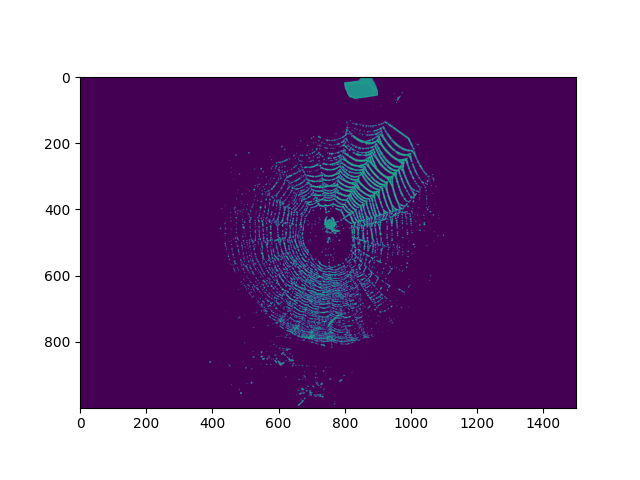

In [12]:
fig, ax = plt.subplots()
ax.imshow(midpoint['merged'])
plt.show()

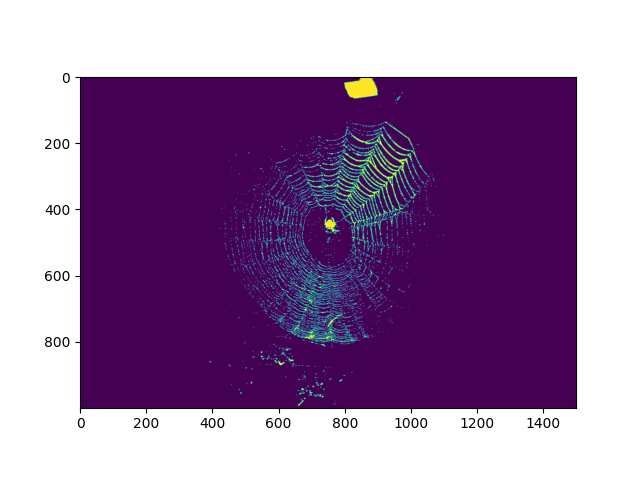

In [13]:
fig, ax = plt.subplots()
ax.imshow(midpoint['dusting'])
plt.show()

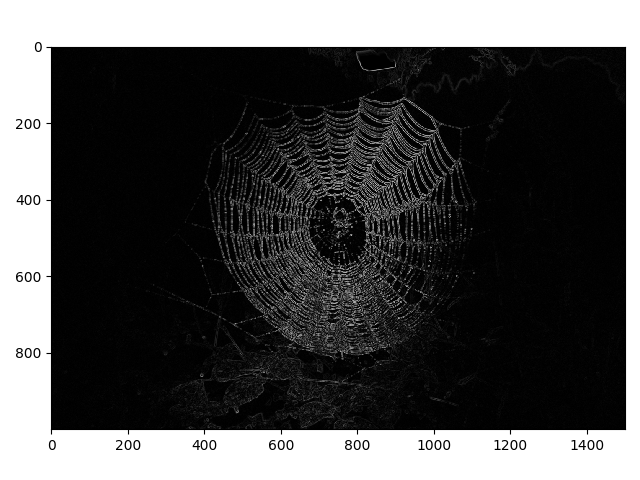

In [14]:
fig, ax = plt.subplots()
io.imshow(midpoint['scharr'])
plt.show()